### PuLP

In [4]:
import pulp as lp
import numpy as np
import matplotlib.pyplot as plt

# Datos proporcionados
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()
T = T.tolist()

N = len(T)  # Número de trabajos
M = len(T[0])  # Número de máquinas
P = 100000  # Una constante grande, suficiente para actuar como 'M' en el modelo

# Crear el modelo
model = lp.LpProblem("Liao-You_Model", lp.LpMinimize)

# Definir las variables
D = lp.LpVariable.dicts("D", (range(N), range(N)), cat='Binary')
S = lp.LpVariable.dicts("S", (range(M), range(N)), lowBound=0, cat='Integer')
q = lp.LpVariable.dicts("q", (range(M), range(N), range(N)), lowBound=0,cat='Integer')
C_max = lp.LpVariable("C_max", lowBound=0, cat='Integer')

# Función objetivo
model += C_max

# Restricciones

# Flujo de trabajos en cada máquina
for r in range(M-1):
    for i in range(N):
        model += S[r][i] + T[r][i] <= S[r+1][i], f"Job_Flow_{i}_{r}"

# Secuencia de trabajos en cada máquina
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):
            model += S[r][i] - S[r][k] + P * D[i][k] - T[r][k] == q[r][i][k], f"Job_Sequence_{r}_{i}_{k}"

# Precedencia de trabajos en las máquinas
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):           
            model += P - T[r][i] - T[r][k] >= q[r][i][k], f"Surplus_Positive_{r}_{i}_{k}"

# Restricciones de makespan
for i in range(N):
    model += C_max >= S[M-1][i] + T[M-1][i], f"Job_Completion_{i}"

# Resolver el modelo
model.solve()

# Imprimir la solución
print(f"Valor óptimo (Cmax): {model.objective.value()}")

# Carta gantt
matriz = []
for r in range(M):
    maquina = []
    for i in range(N):
        maquina.append([int(lp.value(S[r][i])),int(lp.value(S[r][i]) + T[r][i])])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, lp.value(model.objective))
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[j])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(j+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold') 

[nan  1.  0.  0.]
[nan nan  0.  0.]
[nan nan nan  0.]
[nan nan nan nan]
[14. 23.  6.  0.]
[28. 46. 16.  6.]
[42. 63. 28. 16.]
[61. 81. 43. 28.]
[[      nan 9.998e+04 0.000e+00 8.000e+00]
 [      nan       nan 9.000e+00 1.700e+01]
 [      nan       nan       nan 0.000e+00]
 [      nan       nan       nan       nan]]
[[       nan 9.9965e+04 0.0000e+00 1.2000e+01]
 [       nan        nan 1.8000e+01 3.0000e+01]
 [       nan        nan        nan 0.0000e+00]
 [       nan        nan        nan        nan]]
[[       nan 9.9961e+04 0.0000e+00 1.4000e+01]
 [       nan        nan 2.1000e+01 3.5000e+01]
 [       nan        nan        nan 0.0000e+00]
 [       nan        nan        nan        nan]]
[[       nan 9.9956e+04 0.0000e+00 1.8000e+01]
 [       nan        nan 2.0000e+01 3.8000e+01]
 [       nan        nan        nan 0.0000e+00]
 [       nan        nan        nan        nan]]
Valor óptimo (Cmax): 105.0


### CPLEX

In [2]:
import cplex
from cplex.exceptions import CplexError

# Datos proporcionados
T = [[9, 13, 15, 20], [11, 17, 18, 24], [8, 12, 14, 18], [6, 10, 12, 15]]
N = len(T)  # Número de trabajos
M = len(T[0])  # Número de máquinas
P = 9999  # Una constante grande

try:
    # Crear el modelo
    model = cplex.Cplex()
    model.set_problem_type(cplex.Cplex.problem_type.LP)

    # Definir la matriz D_ik
    D_ik = {(i, k): 1 if i < k else 0 for i in range(1, N+1) for k in range(1, N+1)}
    S = LpVariable.dicts("Start_Time", [(r, i) for r in range(1, M+1) for i in range(1, N+1)], lowBound=0)

    # Definir las variables
    start_times = ["Start_Time_{}_{}".format(r, i) for r in range(1, M+1) for i in range(1, N+1)]
    surplus_vars = ["Surplus_{}_{}_{}".format(r, i, k) for r in range(1, M+1) for i in range(1, N) for k in range(i+1, N+1)]
    makespan_var = ["Makespan"]

    model.variables.add(names=start_times, types=[model.variables.type.continuous] * len(start_times))
    model.variables.add(names=surplus_vars, types=[model.variables.type.continuous] * len(surplus_vars))
    model.variables.add(names=makespan_var, types=[model.variables.type.continuous])

    # Función objetivo
    model.objective.set_sense(model.objective.sense.minimize)
    model.objective.set_linear([(makespan_var[0], 1)])

    # Restricciones
    # Flujo de trabajos en cada máquina
    for i in range(1, N+1):
        for r in range(1, M):
            model += S[r, i] + T[i-1][r-1] <= S[r+1, i], f"Job_Flow_{i}_{r}"


    # Secuencia de trabajos en cada máquina
    for r in range(1, M+1):
        for i in range(1, N):
            model += S[r, i] + T[i-1][r-1] <= S[r, i+1], f"Job_Sequence_{r}_{i}"

    # Precedencia de trabajos en las máquinas
    for r in range(1, M+1):
        for i in range(1, N):
            for k in range(i+1, N+1):
                model += S[r, i] - S[r, k] + P * D_ik[(i, k)] - T[k-1][r-1] == q[r, i, k], f"Job_Precedence_{r}_{i}_{k}"
                model += P - T[i-1][r-1] - T[k-1][r-1] >= q[r, i, k], f"Surplus_Positive_{r}_{i}_{k}"

    # Restricciones de makespan
    for i in range(1, N+1):
        model += Cmax >= S[M, i] + T[i-1][M-1], f"Job_Completion_{i}"

    # Resolver el modelo
    model.solve()

    # Imprimir la solución
    solution = model.solution
    print("Valor óptimo (Cmax):", solution.get_objective_value())
    for v in start_times + surplus_vars + makespan_var:
        print(v, "=", solution.get_values(v))

except CplexError as exc:
    print(exc)

NameError: name 'LpVariable' is not defined

### Gurobi

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 64 rows, 81 columns and 128 nonzeros
Model fingerprint: 0x342060e5
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+04]
Presolve removed 45 rows and 64 columns
Presolve time: 0.00s
Presolved: 19 rows, 17 columns, 51 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8000000e+01   1.254496e+03   0.000000e+00      0s
      10    7.7000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.700000000e+01
Start_Time[0,0] = 0.0
Start_Time[0,1] = 9.0
Start_Time[0,2] = 9985.

NameError: name 'value' is not defined

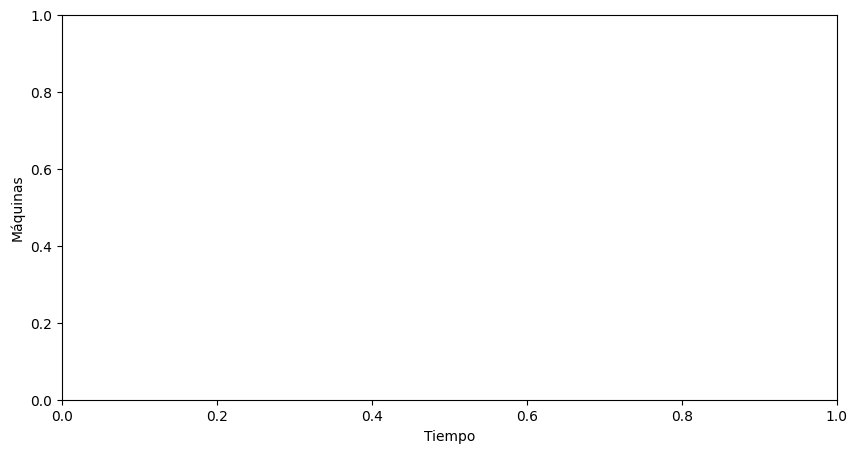

In [1]:
from gurobipy import Model, GRB
import numpy as np
import matplotlib.pyplot as plt

# Datos proporcionados
T = [[9, 13, 15, 20], [11, 17, 18, 24], [8, 12, 14, 18], [6, 10, 12, 15]]
N = len(T)  # Número de trabajos
M = len(T[0])  # Número de máquinas
P = 9999  # Una constante grande

# Crear el modelo
model = Model("Liao-You_Model")

# Definir la matriz D_ik
D_ik = {(i, k): 1 if i < k else 0 for i in range(1, N+1) for k in range(1, N+1)}

# Definir las variables
S = model.addVars(M, N, vtype=GRB.CONTINUOUS, name="Start_Time")
q = model.addVars(M, N, N, vtype=GRB.CONTINUOUS, name="Surplus")
Cmax = model.addVar(vtype=GRB.CONTINUOUS, name="Makespan")

# Función objetivo
model.setObjective(Cmax, GRB.MINIMIZE)

# Restricciones
for r in range(M):
    for i in range(N-1):
        model.addConstr(S[r, i] + T[i][r] <= S[r, i+1], f"Job_Sequence_{r}_{i}")

for r in range(M):
    for i in range(N):
        for k in range(i+1, N):
            model.addConstr(S[r, i] - S[r, k] + P * D_ik[(i+1, k+1)] - T[k][r] == q[r, i, k], f"Job_Precedence_{r}_{i}_{k}")
            model.addConstr(P - T[i][r] - T[k][r] >= q[r, i, k], f"Surplus_Positive_{r}_{i}_{k}")

for i in range(N):
    model.addConstr(Cmax >= S[M-1, i] + T[i][M-1], f"Job_Completion_{i}")

# Resolver el modelo
model.optimize()

# Imprimir la solución
for v in model.getVars():
    if v.VarName.startswith('Start_Time') or v.VarName == 'Makespan':
        print(f"{v.VarName} = {v.X}")

        

# Crear la figura y el subplot de la carta Gantt
fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, value(Cmax))
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

# Colores para cada trabajo
colores = ['#00BB00', 'blue', 'red', '#EECC00']

# Dibujar las barras en la carta Gantt
for i in range(1, M+1):
    for j in range(1, N+1):
        inicio = S[(i, j)].varValue
        duracion = T[j-1][i-1]
        gantt.broken_barh([(inicio, duracion)], ((i-1) * 10, 9), facecolors=colores[j-1])
        gantt.text(inicio + duracion / 2, (i-1) * 10 + 4.5, f'J{j}', va='center', ha='center', color='white')

# Mostrar la carta Gantt
plt.show()